In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import random

import torch
import torch.nn as nn
from torch.nn import Parameter
#import torchoptics
#from torchoptics import System
#from torchoptics.elements import PhaseModulator
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from matplotlib.colors import hsv_to_rgb
import matplotlib.ticker as ticker

In [2]:
# Check if GPU is registered and being used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

devNumber = torch.cuda.current_device()
print(f"The current device number is {devNumber}")

dev_name = torch.cuda.get_device_name(devNumber)
print(f"GPU is {dev_name}")

Using Device: cuda
The current device number is 0
GPU is NVIDIA GeForce RTX 2060


In [3]:
# Make a vectorising function
def vectorise(field):
    x = field.shape[0]
    y = field.shape[1]
    return field.reshape(x*y,1)

# Make an unvectorising function
def unvectorise(field, dim):
    return field.reshape(dim,dim)

def Complex2HSV(z, rmin, rmax, hue_start=90):
    # get amplidude of z and limit to [rmin, rmax]
    amp = np.abs(z)
    amp = np.where(amp < rmin, rmin, amp)
    amp = np.where(amp > rmax, rmax, amp)
    ph = np.angle(z, deg=1)# + hue_start
    # HSV are values in range [0,1]
    h = (ph % 360) / 360
    s = 0.85 * np.ones_like(h)
    v = (amp -rmin) / (rmax - rmin)
    return hsv_to_rgb(np.dstack((h,s,v)))

# Make a gaussian function
def gaussian(A, sigma, shape, mux=0, muy=0, warpx=0,warpy=0, B=0):
    """Makes a gaussian tensor of size = shape*shape. Intensity = A. Half-width = sigma. 
    Off-centre with 'mux' and 'muy' (-1 to +1). Or warp the shape with 'warpx' and 'warpy'."""
    X, Y = np.meshgrid(np.linspace((-1-mux)*(1+warpy), (1-mux)*(1+warpy), shape), np.linspace((-1+muy)*(1+warpx), (1+muy)*(1+warpx), shape))
    Z = (X**2 + Y**2)**0.5
    gauss = A * np.exp(-(Z**2)/(2*sigma**2)) + B
    return torch.from_numpy(gauss)

def gaussian_torch(shape, mean, std):
    x, y = np.meshgrid(np.linspace(-1, 1, shape), np.linspace(-1, 1, shape))
    d = np.sqrt(x**2 + y**2)
    gaussian = np.exp(-((d - mean)**2 / (2.0 * std**2)))
    gaussian = torch.from_numpy(gaussian)
    return gaussian

# Make FFT functions
def fft2(field: torch.Tensor) -> torch.Tensor:
    """2D discrete forward fourier transform."""
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(field)))

def ifft2(field: torch.Tensor) -> torch.Tensor:
    """2D discrete inverse fourier transform."""
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(field)))

# Make a propagation function using these fft2 functions that works on GPU
def prop(field_in, kz, distance):
    """Propagation of a 2D field using the fft2 functions."""
    field_in_ft = fft2(field_in)
    field_out_ft = field_in_ft * torch.exp(1j*kz*distance)
    field_out = ifft2(field_out_ft)
    return field_out

def mseloss(output, target):
    return (output.abs()-target.abs()).abs().square().sum()

def loss_fn(output, target):
    return (output.abs().square() - target.abs().square()).abs().sum()

In [4]:
a = torch.tensor([[1+1j,2,3],[4,5-8j,6],[7,8,9+2j]])
print(a.abs().square().sum())
print(torch.sum(abs(a)**2))

tensor(354.)
tensor(354.)


In [5]:
class Field(torch.Tensor):
    """Class designed around a 2D electric field represented by a torch tensor."""
    wl = 700e-9 #[m]
    k = torch.tensor(2*np.pi/wl) #[1/m]
    k_x = 1235678
    k_y = 3457437
    k_z = (torch.abs(k)**2 - k_x**2 - k_y**2)**0.5 #[1/m]
    
    def __init__(self, tensor):
        self = tensor

    def normalise(self):
        return self / torch.linalg.matrix_norm(self)

    def visualise(self, figsize=(10,5),title=""):
        """Displays a visual plot of the field, using hsv colour mapping to demonstrate the 
        fields phase (Hue) and amplitude (Value)."""
        # Set up plots
        fig, axs = plt.subplots(1,2, figsize=figsize)

        # Plot the given field
        axs[0].imshow(Complex2HSV(self, 0, 0.025))

        # Colour bar
        V, H = np.mgrid[0:1:100j, 0:1:300j]
        S = np.ones_like(V)
        HSV = np.dstack((H,S,V))
        RGB = hsv_to_rgb(HSV)

        axs[1].imshow(RGB, origin="lower", extent=[0, 2*np.pi, 0, 1], aspect=15)

        axs[1].set_xticks([0, np.pi, 2*np.pi], ['0', '$\pi$', '$2\pi$'])
        axs[1].set_yticks([0, 1], ['0', '1'])

        axs[1].set_ylabel("Amplitude")
        axs[1].set_xlabel("Phase (rad.)")

        fig.show()

Text(0.5, 0, '$k_z$')

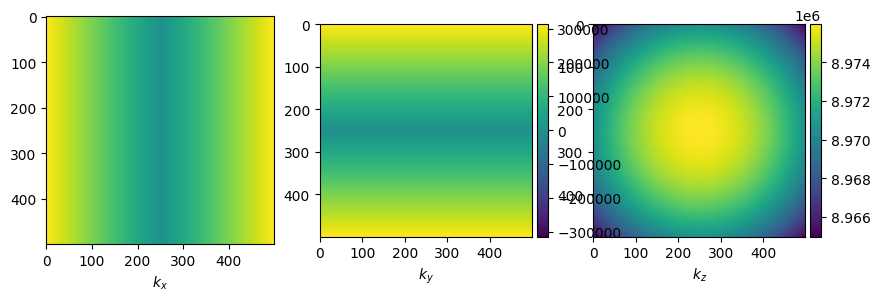

In [6]:
pix_size = 1e-5 #[m]
grid_size = 500 # Number of pixels per side of the grid
grid_length = pix_size * grid_size # Length of grid in real space coords
wl = 700e-9 #[m]
#print(grid_length)

Nx = np.arange(-grid_size/2,grid_size/2,1)
Ny = np.arange(-grid_size/2,grid_size/2,1)
X,Y = np.meshgrid(Nx,Ny)
X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

alpha = torch.tensor(0.05)
beta = torch.tensor(0.05)

# Make the Kx, Ky and Kz grids.
# Start with making arrays of the right size to append correct values onto later.
Kx = np.ones((grid_size,grid_size))
Ky = np.ones((grid_size,grid_size))

for y,i in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
    for x,j in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
        Kx[i,j] = (2*np.pi*x)/grid_length
        Ky[i,j] = (2*np.pi*y)/grid_length

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
minmin = np.min([np.min(Kx), np.min(Ky)])
maxmax = np.max([np.max(Kx), np.max(Ky)])

#im1 = axs[0].imshow(Kx, vmin=minmin, vmax=maxmax)
#im2 = axs[1].imshow(Ky, vmin=minmin, vmax=maxmax)
im1 = axs[0].imshow(np.abs(Kx), vmin=minmin, vmax=maxmax)
im2 = axs[1].imshow(np.abs(Ky), vmin=minmin, vmax=maxmax)

axs[0].set_xlabel("$k_x$")
axs[1].set_xlabel("$k_y$")

divider1 = make_axes_locatable(axs[1])
divider2 = make_axes_locatable(axs[2])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
   
plt.colorbar(im2, cax=cax1)

Kz = torch.from_numpy(((2*np.pi/wl)**2 - Kx**2 - Ky**2)**0.5)#.type(torch.cfloat)

im3 = axs[2].imshow(Kz)
plt.colorbar(im3,cax=cax2)
axs[2].set_xlabel("$k_z$")

In [7]:
# Make the tilt phase mask function
def tilt2d(field_in: torch.Tensor, X: torch.Tensor, Y: torch.Tensor, wl:float, alpha: float=0.0, beta: float=0.0) -> torch.Tensor:
    """Adds tilted phase to a 2D complex field."""
    tilt_phase = (-2*np.pi/wl)*(X*torch.sin(torch.deg2rad(torch.tensor(alpha))) + Y*torch.sin(torch.deg2rad(torch.tensor(beta))))
    field_out = field_in * torch.exp(1j*tilt_phase.to(device))
    #field_out = torch.abs(field_in) * torch.exp(1j*(tilt_phase+torch.angle(field_in)))
    return field_out

def tilt_phase_mask(X: torch.Tensor, Y: torch.Tensor, wl:float, alpha: float=0.0, beta: float=0.0) -> torch.Tensor:
    """Makes the tilt phase mask field, useful for plotting what the mask looks like."""
    return torch.exp(1j*(-2*np.pi/wl)*(X*torch.sin(torch.deg2rad(torch.tensor(alpha))) + Y*torch.sin(torch.deg2rad(torch.tensor(beta)))))

In [8]:
# Construct a Frenel Lens
def frenel_lens_mask(X:torch.Tensor, Y:torch.Tensor,wl:float, f:float=0.1):
    """frenel lens phase mask"""
    lens_phase = (2*np.pi/wl) * (f - (X**2 + Y**2 + f**2)**0.5)
    return torch.exp(1j*lens_phase)

def frenel2d(field_in:torch.Tensor, X:torch.Tensor, Y:torch.Tensor,wl:float, f:float=0.1):
    """Apply frenel lens phase mask onto a 2D input field."""
    lens_phase = (2*np.pi/wl) * (f - (X**2 + Y**2 + f**2)**0.5)
    field_out = field_in * torch.exp(1j*lens_phase)
    return field_out

# Model work

In [9]:
class TiltModel(nn.Module):
    wl = 700e-9 #[m]
    pix_size = 1e-5 #[m]
    distance = 0.3 #[m]

    def __init__(self, grid_size=500, alpha=0.0, beta=0.0, z1=0.15):
        super(TiltModel,self).__init__()
        
        self.grid_size = grid_size # Number of pixels per side of the grid
        self.grid_length = pix_size * grid_size # Length of grid in real space coords
        self.alpha = alpha
        self.beta = beta
        # Parameters
        self.z1 = nn.Parameter(data=torch.tensor([z1], dtype=torch.float32, requires_grad=True))

        Nx = np.arange(-grid_size/2,grid_size/2,1)
        Ny = np.arange(-grid_size/2,grid_size/2,1)
        X,Y = np.meshgrid(Nx,Ny)
        X = torch.from_numpy(X)
        Y = torch.from_numpy(Y)

        # Make the Kx, Ky and Kz grids.
        Kx = np.ones((grid_size,grid_size))
        Ky = np.ones((grid_size,grid_size))

        for y,i in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
            for x,j in zip(np.arange(-grid_size/2,grid_size/2,1), np.arange(0,grid_size+1,1)):
                Kx[i,j] = (2*np.pi*x)/grid_length
                Ky[i,j] = (2*np.pi*y)/grid_length
        self.Kz = torch.from_numpy(((2*np.pi/self.wl)**2 - Kx**2 - Ky**2)**0.5).to(device)
        
        self.Xp = X*pix_size
        self.Yp = Y*pix_size

    def forward(self, input_field):
        field_before_mask = prop(input_field, self.Kz, self.z1)
        field_after_mask = tilt2d(field_before_mask, self.Xp, self.Yp, self.wl, self.alpha, self.beta)
        output_field = prop(field_after_mask, self.Kz, (self.distance - self.z1))
        return output_field

C:\Users\elija\AppData\Local\Temp\ipykernel_2556\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


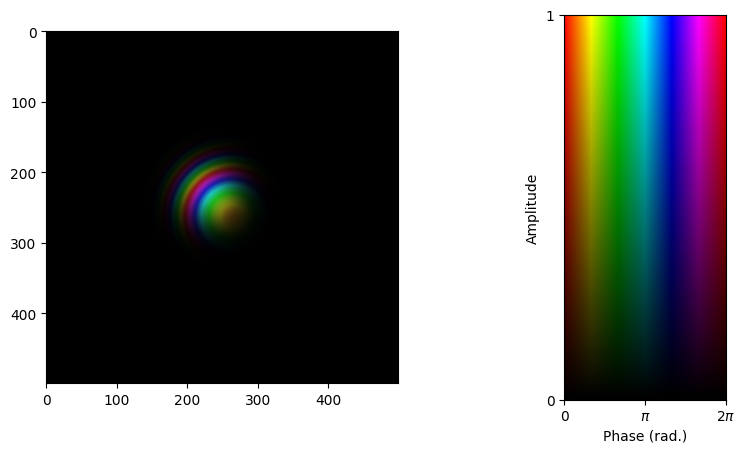

In [10]:
input_field = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
test = TiltModel(alpha=0.05, beta=0.05, z1=0.1).to(device)
test.forward(input_field).detach().cpu().visualise()

In [11]:
Kz_gpu = Kz.to(device)
wl = 700e-9 #[m]

C:\Users\elija\AppData\Local\Temp\ipykernel_2556\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


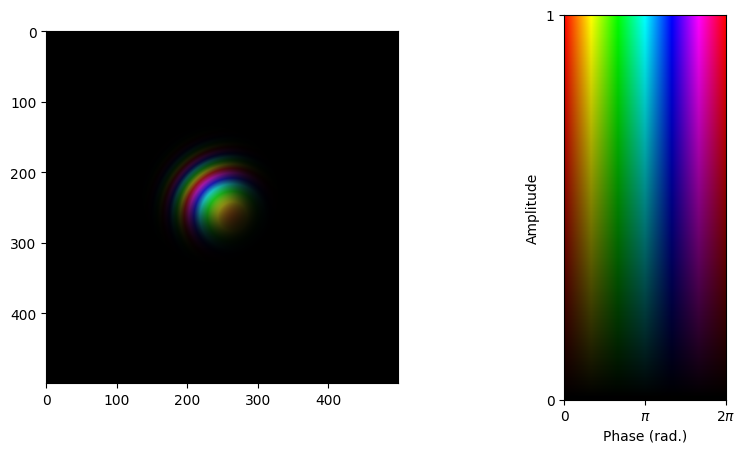

In [12]:
def tilt_forward(field_in, kz, z1, dist, alpha, beta, wl=700e-9):

    Nx = np.arange(-grid_size/2,grid_size/2,1)
    Ny = np.arange(-grid_size/2,grid_size/2,1)
    X,Y = np.meshgrid(Nx,Ny)
    X = torch.from_numpy(X)*pix_size
    Y = torch.from_numpy(Y)*pix_size

    field_before_mask = prop(field_in, kz, z1)
    field_after_mask = tilt2d(field_before_mask, X, Y, wl, alpha, beta)
    target_field = prop(field_after_mask, kz, (dist-z1))
    
    return target_field

input_field = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
tilt_forward(input_field, Kz_gpu, 0.1, 0.3, alpha=0.05, beta=0.05).cpu().visualise()

In [13]:
input_field = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
target = tilt_forward(input_field, Kz_gpu, 0.1, 0.3, alpha=0.05, beta=0.05)
test = TiltModel(alpha=0.05, beta=0.05, z1=0.1).to(device)
output = test.forward(input_field)
loss_fn(output, target).item()

1.124027432394133e-07

C:\Users\elija\AppData\Local\Temp\ipykernel_2556\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\elija\AppData\Local\Temp\ipykernel_2556\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


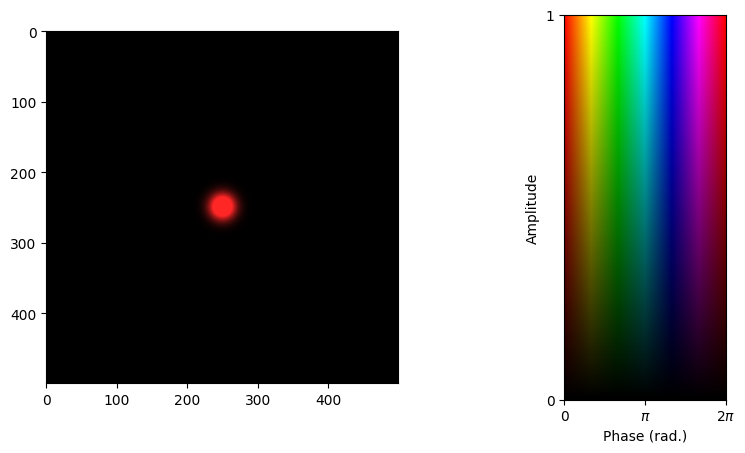

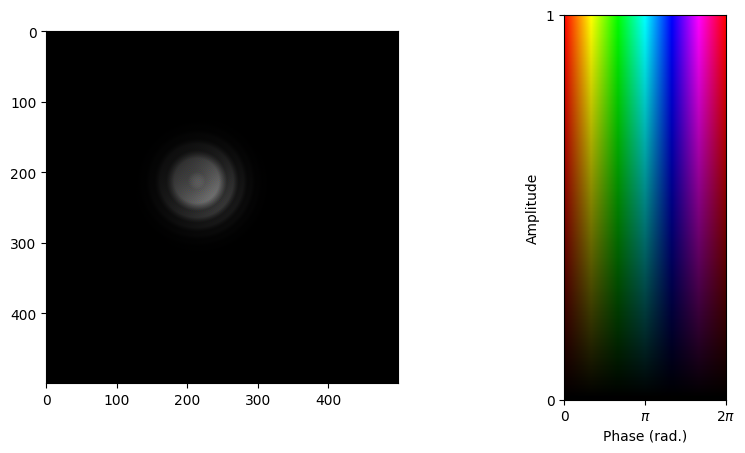

In [14]:
# Form training data (1 input, 1 target)
field_in = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
field_in.cpu().visualise(title="Input Field")
field_before_mask = prop(field_in, Kz_gpu, 0.1)
#field_before_mask.cpu().visualise()
field_after_mask = tilt2d(field_before_mask, X, Y, wl, alpha=0.05, beta=0.05)
#field_after_mask.cpu().visualise()
target_field = prop(field_after_mask, Kz_gpu, 0.2)
target_field.cpu().visualise(title="Target Field")

In [15]:
input_field = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
target_field = tilt_forward(input_field, Kz_gpu, 0.08, 0.3, alpha=0.05, beta=0.05)

In [16]:
# Training Loop
model = TiltModel(alpha=0.05,beta=0.05).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 1000

for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = model(field_in)

    loss = loss_fn(y_pred, target_field)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, z1: {model.z1.item()}, z2: {0.3 - model.z1.item()}")

print(f"Final Loss: {loss.item()}")
print(f"Final z1: {model.z1.item()}")
print(f"Final z2: {0.3 - model.z1.item()}")

Epoch 0, Loss: 0.3275144041194347, z1: 0.14990000426769257, z2: 0.15009999573230742
Epoch 100, Loss: 0.28118000058183995, z1: 0.13988621532917023, z2: 0.16011378467082976
Epoch 200, Loss: 0.23450927341521327, z1: 0.12985217571258545, z2: 0.17014782428741454
Epoch 300, Loss: 0.1875838031136515, z1: 0.11980315297842026, z2: 0.18019684702157973
Epoch 400, Loss: 0.14043410116314808, z1: 0.10974130779504776, z2: 0.19025869220495223
Epoch 500, Loss: 0.09312161500591795, z1: 0.09967249631881714, z2: 0.20032750368118285
Epoch 600, Loss: 0.04572050686584217, z1: 0.08960319310426712, z2: 0.21039680689573287
Epoch 700, Loss: 0.001163780027812354, z1: 0.07972163707017899, z2: 0.220278362929821
Epoch 800, Loss: 2.3727907085418346e-05, z1: 0.07999970763921738, z2: 0.2200002923607826
Epoch 900, Loss: 1.8391495068883194e-05, z1: 0.08000073581933975, z2: 0.21999926418066024
Final Loss: 1.8121621973726223e-05
Final z1: 0.07999765127897263
Final z2: 0.22000234872102736


0
100
200
300
400


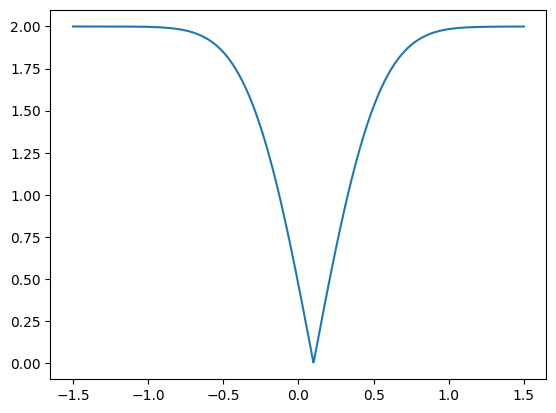

In [17]:
input_field = Field(gaussian_torch(500,0,0.05)).normalise().type(torch.cdouble).to(device)
#print(f"Input: {input_field.is_cuda}")
loss = []
xs = torch.from_numpy(np.linspace(-1.5,1.5,500))
target = tilt_forward(input_field, Kz_gpu, 0.1, 0.3, alpha=0.05, beta=0.05)
for i in range(xs.size()[0]):
    model = TiltModel(alpha=0.05,beta=0.05, z1=xs[i]).to(device)
    #print(next(model.parameters()).is_cuda)
    y_pred = model(input_field)
    #print(f"Target: {target.is_cuda}")
    loss.append(loss_fn(y_pred, target).cpu().detach().numpy())
    if i % 100 == 0:
        print(i)

plt.plot(xs,loss)

# Optimise using a dataset of 10
Want to make a random batch of gaussian input beams. (using a gaussian function with randomised inputs)

In [18]:
# Make a gaussian function
def gaussian(A, sigma, shape, mux=0, muy=0, warpx=0,warpy=0, B=0):
    """Makes a gaussian tensor of size = shape*shape. Intensity = A. Half-width = sigma. 
    Off-centre with 'mux' and 'muy' (-1 to +1). Or warp the shape with 'warpx' and 'warpy'."""
    X, Y = np.meshgrid(np.linspace((-1-mux)*(1+warpy), (1-mux)*(1+warpy), shape), np.linspace((-1+muy)*(1+warpx), (1+muy)*(1+warpx), shape))
    Z = (X**2 + Y**2)**0.5
    gauss = A * np.exp(-(Z**2)/(2*sigma**2)) + B
    return torch.from_numpy(gauss)

C:\Users\elija\AppData\Local\Temp\ipykernel_2556\966520539.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


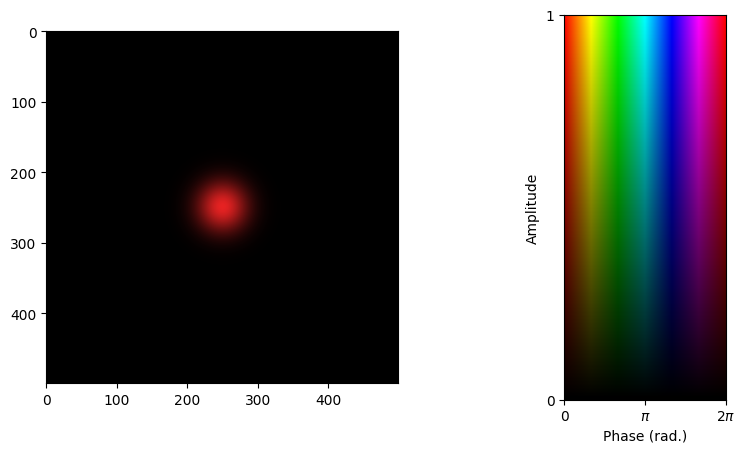

In [63]:
Field(gaussian(1, 0.1, 500)).normalise().visualise()

In [85]:
# Make a function to generate a batch of random gaussian beams.
def rand_gauss_batch(batch: int=10, shape: int=500):
    """Generate random gaussian beams. batch = no. generated."""
    fields = []
    for i in range(batch):
        p1, p2, p3 = random.randrange(-1000,1000)/10000, random.randrange(-500,500)/1000, random.randrange(-500,500)/1000
        rand_gauss = gaussian(1, p1, shape, p2, p3)
        fields.append(rand_gauss)
    return fields

In [89]:
test = rand_gauss_batch(5)
for i in range(5):
    Field(test[i]).normalise()